# a_tree_feature_selection
----

Written in the Python 3.7.9 Environment with the following package versions

    * joblib 1.0.1
    * numpy 1.19.5
    * pandas 1.3.1
    * scikit-learn 0.24.2
    * tensorflow 2.5.0

By Nicole Lund 

This Jupyter Notebook tunes a decision tree model with Exoplanet classification from Kepler Exoplanet study data in order to select the features of greatest importance.

Column descriptions can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html 

**Source Data**

The source data used was provided by University of Arizona's Data Analytics homework assignment. Their data was derived from https://www.kaggle.com/nasa/kepler-exoplanet-search-results?select=cumulative.csv

The full data set was released by NASA at
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi

In [16]:
# Import Dependencies

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from statistics import mean
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

# Parameter Selection
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Development
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Model Metrics
from sklearn.metrics import classification_report

# Save/load files
from tensorflow.keras.models import load_model
import joblib

# # Ignore deprecation warnings
# import warnings
# warnings.simplefilter('ignore', FutureWarning)

In [17]:
# Set the seed value for the notebook, so the results are reproducible
from numpy.random import seed
seed(1)

# Read the CSV and Perform Basic Data Cleaning

In [18]:
# Import data
df = pd.read_csv("b_source_data/exoplanet_data.csv")
# print(df.info())

# Drop columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop rows containing null values
df = df.dropna()

# Display data info
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6991 entries, 0 to 6990
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    6991 non-null   object 
 1   koi_fpflag_nt      6991 non-null   int64  
 2   koi_fpflag_ss      6991 non-null   int64  
 3   koi_fpflag_co      6991 non-null   int64  
 4   koi_fpflag_ec      6991 non-null   int64  
 5   koi_period         6991 non-null   float64
 6   koi_period_err1    6991 non-null   float64
 7   koi_period_err2    6991 non-null   float64
 8   koi_time0bk        6991 non-null   float64
 9   koi_time0bk_err1   6991 non-null   float64
 10  koi_time0bk_err2   6991 non-null   float64
 11  koi_impact         6991 non-null   float64
 12  koi_impact_err1    6991 non-null   float64
 13  koi_impact_err2    6991 non-null   float64
 14  koi_duration       6991 non-null   float64
 15  koi_duration_err1  6991 non-null   float64
 16  koi_duration_err2  6991 

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Pre-processing

Use `koi_disposition` for the y values

In [19]:
# Split dataframe into X and y
X = df.drop("koi_disposition", axis=1)
y = df["koi_disposition"]
print(X.shape, y.shape)

(6991, 40) (6991,)


In [20]:
# Split X and y into training and testing groups
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [21]:
# Display training data
X_train.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
4954,0,0,0,0,97.942437,0.001183,-0.001183,157.97325,0.00888,-0.00888,...,-198,3.806,0.445,-0.194,2.284,0.726,-1.090,288.53769,51.280384,11.366
4235,0,0,1,1,16.609490,0.000141,-0.000141,147.61311,0.00715,-0.00715,...,-210,4.395,0.105,-0.195,1.050,0.323,-0.162,300.43979,43.930729,14.926
848,0,0,0,0,32.275385,0.000541,-0.000541,149.04600,0.01400,-0.01400,...,-103,4.123,0.182,-0.098,1.483,0.230,-0.316,298.29495,48.775459,14.167
2874,0,1,1,1,0.787120,0.000002,-0.000002,131.73939,0.00190,-0.00190,...,-201,4.481,0.150,-0.100,0.787,0.093,-0.103,295.28110,40.132858,14.964
3016,0,0,0,0,6.963527,0.000039,-0.000039,133.01717,0.00435,-0.00435,...,-201,3.978,0.458,-0.153,1.686,0.413,-0.709,296.10406,42.342590,13.128


In [22]:
# Scale the data with MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Determine Features of Influence - Decision Tree Classifier Method

In [23]:
# Create and score a decision tree classifier
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)
print('Decision Tree Score:')
print(tree_clf.score(X_train, y_train))

Decision Tree Score:
1.0


In [24]:
# Sort the features by their importance
tree_feature_sort = sorted(zip(X.columns,tree_clf.feature_importances_),key=itemgetter(1), reverse=True)
# tree_feature_sort

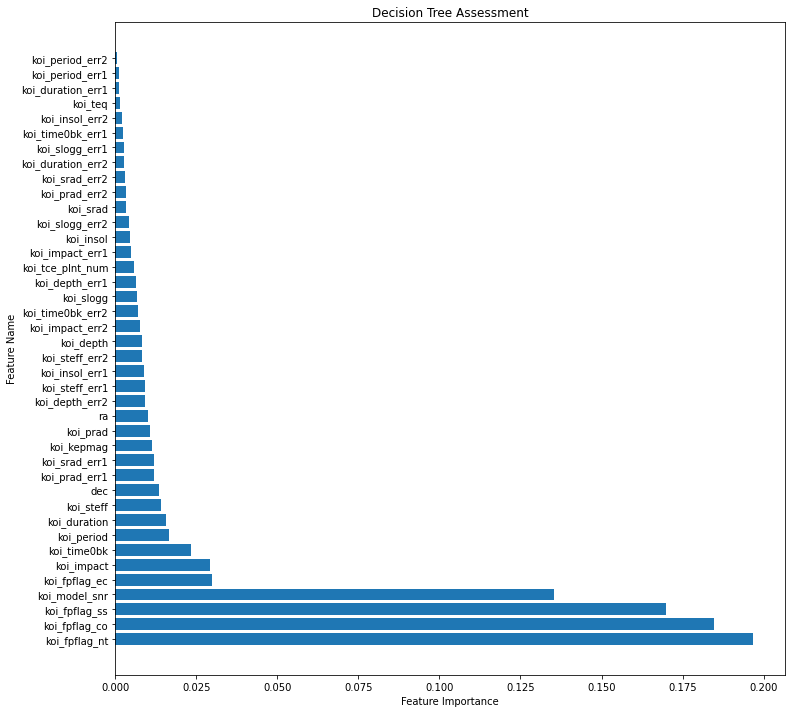

In [25]:
# Plot Decision Tree Feature Importance
fig = plt.figure(figsize=[12,12])
plt.barh(*zip(* (tree_feature_sort)))
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Decision Tree Assessment')
plt.show()

# Choose Features of Importance
From the Decision Tree Assessment plot you can see a large gap in feature importance between koi_fpflag_ec and koi_model_snr. This indicates that features with importance exceeding 0.1 are good candidates for seeding predictive models

In [26]:
# Select Tree Features of Interest
tree_features = [feature[0] for feature in tree_feature_sort if feature[1] > 0.1]
tree_features

['koi_fpflag_nt', 'koi_fpflag_co', 'koi_fpflag_ss', 'koi_model_snr']